In [1]:
import numpy as np
import torch, torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms


from tqdm.notebook import tqdm

In [15]:
# parameters
num_workers = 3
batch_size = 64
n_classes = 10
epochs = 100

chi = 10 # MPS bond dimension

n_sites = 784 # number of pixels
torch.manual_seed(42)
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
learning_rate = 3e-4

## Dataset preparation
We showcase the method on MNIST. MPS process pixels as 2-dim vectors. So, we reshape dataset accordingly. Note, that there are many ways you can represent gray pixels as 2-dim vectors. Most of them should work, I guess.

In [3]:
#dataset loading
trainset = datasets.MNIST('', download=True, train=True, transform=transforms.ToTensor())
valset = datasets.MNIST('', download=True, train=False, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [4]:
#mnist processing for mps 
trainset.data = trainset.data.view(-1, 784)
valset.data = valset.data.view(-1, 784)
XXt, XXv = trainset.data/255., valset.data/255.
Xt = torch.zeros(XXt.size()[0], XXt.size()[1], 2)
Xv = torch.zeros(XXv.size()[0], XXv.size()[1], 2)
Xt[:, :, 0], Xt[:, :, 1] = XXt, 1 - XXt # cos and sin is another popular choice
Xv[:, :, 0], Xv[:, :, 1] = XXv, 1 - XXv
yt, yv = trainset.targets, valset.targets
tensor_trainset = torch.utils.data.TensorDataset(Xt, yt)
tensor_valset = torch.utils.data.TensorDataset(Xv, yv)

In [7]:
train_dataloader = torch.utils.data.DataLoader(
    tensor_trainset, batch_size=batch_size,
    num_workers=num_workers, shuffle=True, pin_memory=True)

val_dataloader = torch.utils.data.DataLoader(
    tensor_valset, batch_size=batch_size,
    num_workers=num_workers, shuffle=False, pin_memory=True)

print(f"Train/val dataloaders have {len(train_dataloader)} and {len(val_dataloader)} batches")

Train/val dataloaders have 938 and 157 batches


In [9]:
dataiter = iter(val_dataloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 784, 2])
torch.Size([64])


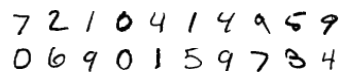

In [10]:
figure = plt.figure()
num_of_images = 20
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index - 1][:, 0].numpy().squeeze().reshape(28, 28), cmap='gray_r')

## Model architecture, MPS

In [11]:
class MPSLayer(torch.nn.Module):
  def __init__(self, n_sites, chi, n_output):
    super(MPSLayer, self).__init__()
    if n_sites % 2:
      raise NotImplementedError("Number of sites should be even but is "
                                  "{}.".format(n_sites))
    self.n_half = n_sites // 2
    self.left = nn.Parameter(self._initializer(self.n_half, 2, chi))
    self.right = nn.Parameter(self._initializer(self.n_half, 2, chi))
    self.middle = nn.Parameter(self._initializer(n_output, 1, chi)[0])

  @staticmethod
  def _initializer(n_sites, d_phys, chi):
    w = torch.stack(d_phys * n_sites * (torch.eye(chi),))
    w = w.view(d_phys, n_sites, chi, chi)
    return w + torch.empty(d_phys, n_sites, chi, chi).normal_(mean=0,std=1e-2)

  @staticmethod
  def reduction(tensor):
    length = tensor.size()[0]
    while length > 1:
      half_length = length // 2
      nice_length = 2*half_length
      leftover = tensor[nice_length:]
      tensor = torch.matmul(tensor[0:nice_length:2], tensor[1:nice_length:2])
      tensor = torch.cat((tensor, leftover), axis=0)
      length = half_length + int(length % 2 == 1)
    return tensor[0]  

  def forward(self, inputs):
    left = torch.einsum("slij,bls->lbij", self.left, inputs[:, :self.n_half])
    right = torch.einsum("slij,bls->lbij", self.right, inputs[:, self.n_half:])
    left = self.reduction(left)
    right = self.reduction(right)
    return torch.einsum("bij,cjk,bki->bc", left, self.middle, right) 

## Training utils 

In [13]:
def validate(model, dataloader):
    """Compute accuracy on the `dataloader` dataset."""
    model.eval()

    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            labels = labels.to(DEVICE)
            probabilities = model(images.to(DEVICE))
            predictions = probabilities.max(1)[1]

            total += len(labels)
            correct += (predictions == labels).sum().item()
            
    return correct / total

def train(model, dataloader, criterion, optimizer):
    """Train for one epoch, return accuracy and average loss."""
    model.train()

    correct, total = 0, 0
    total_loss = 0.0

    for images, labels in tqdm(dataloader):
        probabilities = model(images.to(DEVICE))

        with torch.no_grad():
            labels = labels.to(DEVICE)
            predictions = probabilities.max(1)[1]
            
            total += len(labels)
            correct += (predictions == labels).sum().item()

        loss_value = criterion(probabilities, labels)
        total_loss += loss_value.item() * len(labels)
        
        optimizer.zero_grad()
       

        loss_value.backward()
        optimizer.step()
       
    return correct / total, total_loss / total

def set_learning_rate(optimizer, new_learning_rate):
    """Set learning rates of the optimizer to `new_learning_rate`."""
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_learning_rate

## Model inititialization and training

In [18]:
model = nn.Sequential(
    MPSLayer(n_sites, chi, n_classes),
    nn.LogSoftmax(dim=1)
)
model.to(DEVICE)

trainable_parameters = model.parameters()
criterion = torch.nn.CrossEntropyLoss()

learning_rate = 3e-4
optimizer = torch.optim.Adam(
    trainable_parameters, lr=learning_rate, weight_decay=1e-4)

epochs = 0
train_accuracy, val_accuracy, train_loss = float('nan'), float('nan'), float('nan')

In [19]:
for _ in range(5):
    # Compute validation accuracy
    val_accuracy = validate(model, val_dataloader)
    print(
        f"After {epochs} epochs, training accuracy: {train_accuracy * 100:.2f}%"
        f" (loss {train_loss:.4f}), validation accuracy: {val_accuracy * 100:.2f}%")

    # Train for one epoch
    train_accuracy, train_loss = train(model, train_dataloader, criterion, optimizer)
    epochs += 1

    # Decrease learning rate sometimes
    if epochs in (8, 13, 16):
        learning_rate /= 10
        set_learning_rate(optimizer, learning_rate)
        print(f"Decreasing the learning rate to {learning_rate}")

# Compute final validation accuracy
val_accuracy = validate(model, val_dataloader)
print(
    f"After {epochs} epochs, training accuracy: {train_accuracy * 100:.2f}%"
    f" (loss {train_loss:.4f}), validation accuracy: {val_accuracy * 100:.2f}%")

After 0 epochs, training accuracy: nan% (loss nan), validation accuracy: 13.40%


  0%|          | 0/938 [00:00<?, ?it/s]

After 1 epochs, training accuracy: 90.71% (loss 0.3054), validation accuracy: 95.48%


  0%|          | 0/938 [00:00<?, ?it/s]

After 2 epochs, training accuracy: 95.72% (loss 0.1481), validation accuracy: 96.73%


  0%|          | 0/938 [00:00<?, ?it/s]

After 3 epochs, training accuracy: 96.72% (loss 0.1179), validation accuracy: 97.04%


  0%|          | 0/938 [00:00<?, ?it/s]

After 4 epochs, training accuracy: 97.09% (loss 0.1026), validation accuracy: 96.79%


  0%|          | 0/938 [00:00<?, ?it/s]

After 5 epochs, training accuracy: 97.39% (loss 0.0924), validation accuracy: 97.28%
